In [1]:
ls ../scotus/data


scotus_filtered.rda


In [2]:
pip install -q pyreadr


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch.nn as nn
import torch
from skorch import NeuralNetRegressor

In [4]:
import pandas as pd
import pyreadr
result = pyreadr.read_r('../scotus/data/scotus_filtered.rda')

In [5]:
df = result["scotus_filtered"]

# EDA

In [6]:
df["text"].apply(len).describe()

count     10000.000000
mean      25857.630400
std       30323.922087
min        1001.000000
25%        8024.500000
50%       16167.500000
75%       32483.000000
max      761526.000000
Name: text, dtype: float64

In [7]:
df.year

0       1903
1       1987
2       1957
3       1913
4       1826
        ... 
9995    1904
9996    1827
9997    1947
9998    1982
9999    1998
Name: year, Length: 10000, dtype: object

# Embeddings

In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')


In [8]:
df["text_embedding"] = df["text"].apply(lambda x: model.encode(x))

In [9]:
embedding_df = pd.DataFrame(df.text_embedding.tolist(), index= df.index)
embedding_df.to_csv("../scotus_embeddings/sbert-scotus_embeddings.csv")

# Train

In [13]:
embedding_df = pd.read_csv("../scotus_embeddings/sbert-scotus_embeddings.csv")

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding_df.to_numpy(),df.year.apply(float).to_numpy())

## XGBoost

In [12]:
import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, max_depth=5, seed = 123)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = clf.predict(X_test)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

24.821607902376165


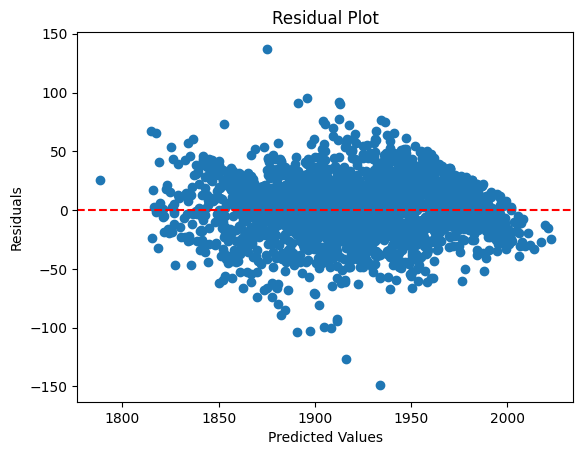

In [ ]:
# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], residuals[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [15]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,0.130010
std,24.826233
min,-148.661377
25%,-14.473419
50%,0.059509
75%,15.289001
max,137.070435


## MLP

In [9]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
input_dim = X_train.shape[1]
net = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=input_dim,
    max_epochs=200,
    lr=0.01,
    optimizer=torch.optim.Adam,
)

param_distributions = {
    'module__hidden_dim1': [64, 128, 256],
    'module__hidden_dim2': [64, 128, 256],
    'module__dropout': [0.1, 0.3, 0.5],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random samples
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)


In [17]:
search.fit(X_train.astype('float32'), y_train.astype('float32').reshape(-1, 1))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1184377.0885   931261.4252  0.1224
      2   939540.0840   924360.2010  0.1030
      3   932422.9857   914939.0010  0.0895
      4   915683.7265   911662.2695  0.0942
      5   902125.9572   886737.9780  0.0910
      6   875646.0047   852673.9082  0.0935
      7   825117.2970   793811.9595  0.0942
      8   740617.1203   627989.9847  0.1085
      9   517288.4710   312104.5635  0.1240
     10   232275.3147   100310.2344  0.0913
     11   128838.4402    72074.1534  0.1012
     12   114289.4744    65096.8222  0.1156
     13   109048.6199    76025.1403  0.1026
     14   112549.2326    61717.9549  0.1131
     15   104906.9777    78609.1554  0.1088
     16   111051.8523    61515.6370  0.1099
     17   104243.4925    56157.9805  0.1078
     18   110628.7022    70355.2205  0.1042
     19   100641.4020    88090.7629  0.1052
     20   10040

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.MLPRegression'>,
  module__input_dim=385,
),
                   n_iter=20,
                   param_distributions={'batch_size': [32, 64, 128],
                                        'lr': [0.001, 0.01, 0.1],
                                        'module__dropout': [0.1, 0.3, 0.5],
                                        'module__hidden_dim1': [64, 128, 256],
                                        'module__hidden_dim2': [64, 128, 256]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [18]:
best_params = search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'module__hidden_dim2': 256, 'module__hidden_dim1': 128, 'module__dropout': 0.1, 'lr': 0.01, 'batch_size': 64}


In [19]:
hidden_dim1 = best_params['module__hidden_dim1']
hidden_dim2 = best_params['module__hidden_dim2']
dropout = best_params['module__dropout']
lr = best_params['lr']
batch_size = best_params['batch_size']


clf = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=X_train.shape[1],
    module__hidden_dim1=hidden_dim1,
    module__hidden_dim2=hidden_dim2,
    module__dropout=dropout,
    max_epochs=1000,
    lr=lr,
    batch_size=batch_size,
    optimizer=torch.optim.Adam,
    verbose=1
)

clf.fit(X_train.astype('float32'), y_train.astype('float32').reshape(-1, 1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1005719.8088   866540.2630  0.1015
      2   673779.1411   203977.6795  0.0892
      3   214760.8480    89295.7661  0.0911
      4   117315.1201    88272.6286  0.0916
      5    85910.9736    52358.7347  0.0881
      6   178684.1273    80395.1858  0.0925
      7   126715.0085    51078.5833  0.0879
      8    74864.8823    43930.3457  0.0916
      9    68664.6589    48950.2986  0.0935
     10    76495.4511    43986.8781  0.0891
     11    65150.3001    43116.0487  0.0878
     12    65156.9376    37771.9967  0.0886
     13    59054.6501    37952.2032  0.0890
     14    71673.5960    55365.2034  0.0934
     15    55591.3872    33251.2133  0.0880
     16    51317.4111    39682.3765  0.0945
     17    55020.2818    30880.1902  0.0875
     18    53877.3414    36980.0279  0.0909
     19   103333.2544    53094.5371  0.0881
     20    62879.4363   104966.2818  0.0882
     21    73917.4729    40134.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLPRegression(
    (model): Sequential(
      (0): Linear(in_features=385, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): ReLU()
      (5): Linear(in_features=256, out_features=1, bias=True)
    )
  ),
)

In [20]:
y_pred = clf.predict(X_test.astype('float32'))

48.06690607334331


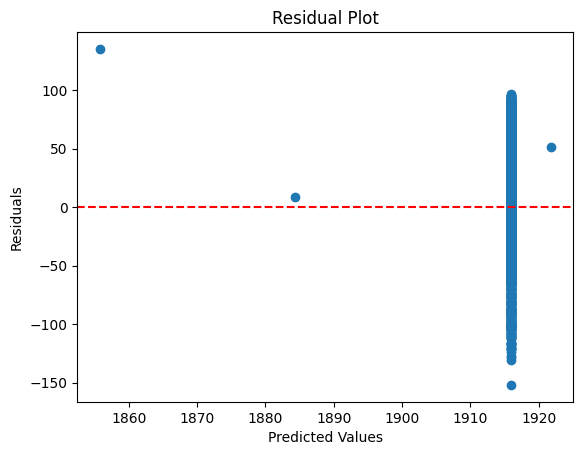

In [21]:

residuals = y_test.reshape(-1, 1) - y_pred

rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

In [22]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,5.183908
std,47.796112
min,-151.972900
25%,-27.972900
50%,2.027100
75%,45.027100
max,135.236206
